<a href="https://colab.research.google.com/github//pylabel-project/samples/blob/main/albumentations.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;
<a href='https://pylabel.readthedocs.io/en/latest/?badge=latest'>
    <img src='https://readthedocs.org/projects/pylabel/badge/?version=latest' alt='Documentation Status' />
</a>
# Using PyLabel and Albumentations
Based on https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb

In [3]:
%pip install pylabel 
%pip install -q -U albumentations

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip uninstall opencv-python-headless
%pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /Users/alex/Code/samples/venv/lib/python3.8/site-packages/cv2/*
    /Users/alex/Code/samples/venv/lib/python3.8/site-packages/opencv_python_headless-4.1.2.30.dist-info/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Setup dependencies 
%matplotlib inline

from pylabel import importer
import albumentations as A

import os, zipfile
from pathlib import PurePath
from os.path import exists
from decimal import *
import copy
import cv2
from matplotlib import pyplot as plt

## Download Custom Dataset 
For this demonstration we will download 100 images from the <a href="https://github.com/pylabel-project/datasets_models#squirrels-and-nuts">squirrels and nuts dataset with annotations in YOLOv5 format.</a> PyLabel can also import datasets in COCO and PASCAL VOC format. 

In [46]:
%%capture
os.makedirs("data/", exist_ok=True)
!wget "https://github.com/pylabel-project/datasets_models/blob/main/squirrelsandnuts/squirrelsandnuts_train.zip?raw=true" -O data/squirrelsandnuts_train.zip
with zipfile.ZipFile("data/squirrelsandnuts_train.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [47]:
#Import annotations as a PyLabel dataset
dataset = importer.ImportYoloV5(path="data/squirrelsandnuts_train/labels/train",
        path_to_images="../../images/train", 
        img_ext="jpeg",
        cat_names=['Squirrel','Nut']
    )
dataset.df.head(3)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,../../images/train,2021-07-03T06-30-10-frame_0001.jpeg,NaN,0,960,540,3,NaN,255.024,170.991,...,NaN,NaN,NaN,NaN,NaN,0,Squirrel,NaN,NaN,1
1,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,650.016,447.984,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1
2,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,690.480,422.010,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1


## Use albumentations to augment images and bounding boxes

In [48]:
#Create a list of the transforms that you want to perform. 
#A seperate augmented image will be created for each item in the list
transforms = [
        [A.HorizontalFlip(p=1), A.GaussianBlur(p=1)],
        [A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2)],
        [A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False,p=1)],
        [A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=1)]
    ]

#Iterate the rows for each image in the dataframe
for img_filename, img_df in dataset.df.groupby('img_filename'):
    img_path = PurePath(dataset.path_to_annotations, str(img_df.iloc[0].img_folder), img_filename)
    img_path_str = str(img_path)
    assert exists(img_path_str), f"File does not exist: {img_path_str}"

    #Create a list of bounding boxes for each image in the dataset  
    bboxes = []
    for index, row in img_df.iterrows():
        #arranges labels in this format [x_min, y_min, x_max, y_max, label]

        #Get bounding box coordinates and make sure that they don't extend beyond image boundary
        xmin = float(Decimal(row.ann_bbox_xmin).max(0))
        ymin = float(Decimal(row.ann_bbox_ymin).max(0))
        xmax = float(Decimal(row.ann_bbox_xmax).min(row.img_width))
        ymax = float(Decimal(row.ann_bbox_ymax).min(row.img_height))
        label = row.cat_name
        
        bboxes.append([xmin, ymin, xmax, ymax, label])

    for index, t in enumerate(transforms):
        transform = A.Compose(t, bbox_params=A.BboxParams(format="pascal_voc"))

        #prepare the annotations to be transformed
        image = cv2.imread(img_path_str)

        transformed = transform(image=image, bboxes=bboxes)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']

        #Save the augmented image, append _augmented to the name of the new image
        augmented_file_name = img_path.stem + "_augmented_" + str(index) + img_path.suffix
        augmented_path_str = str(PurePath(img_path.parent, augmented_file_name) )
        cv2.imwrite(augmented_path_str, transformed_image)

        #Add the annotations to the PyLabel dataframe 

        new_img_id = dataset.df.img_id.max() + 1

        for bbox in transformed_bboxes:
            xmin, ymin, xmax, ymax, label = bbox
            
            new_row = copy.deepcopy(img_df.iloc[0])
            new_row.img_filename = augmented_file_name
            new_row.img_id = new_img_id
            new_row.ann_bbox_xmin = xmin
            new_row.ann_bbox_ymin = ymin
            new_row.ann_bbox_xmax = xmax
            new_row.ann_bbox_ymax = ymax
            new_row.cat_name = label
            dataset.df = dataset.df.append(new_row)

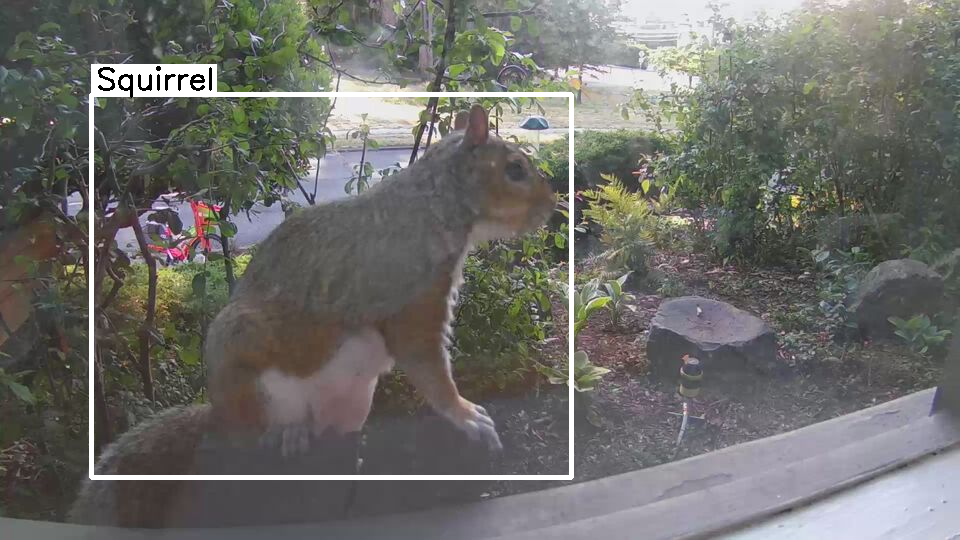

In [43]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T07-23-10-frame_0002.jpeg")

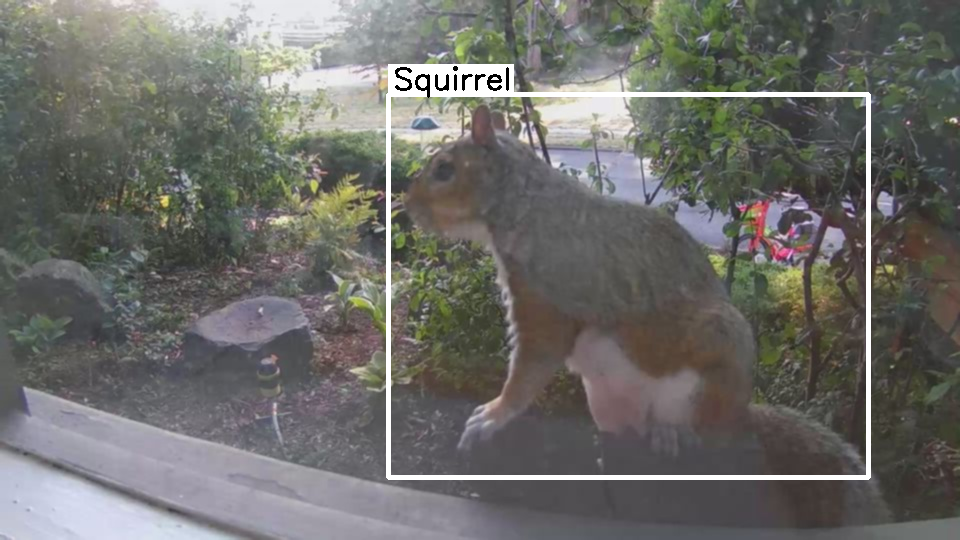

In [44]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T07-23-10-frame_0002_augmented_0.jpeg")

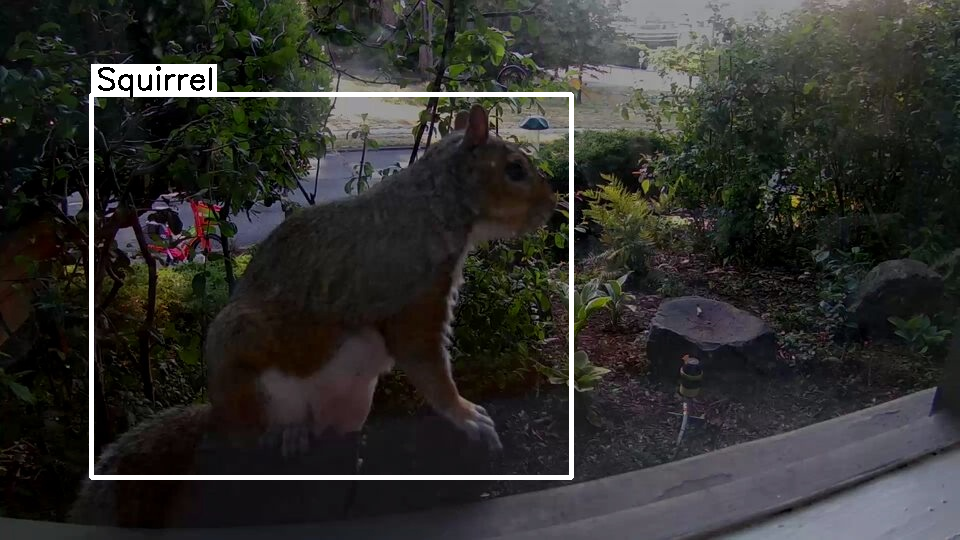

In [50]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T07-23-10-frame_0002_augmented_2.jpeg")

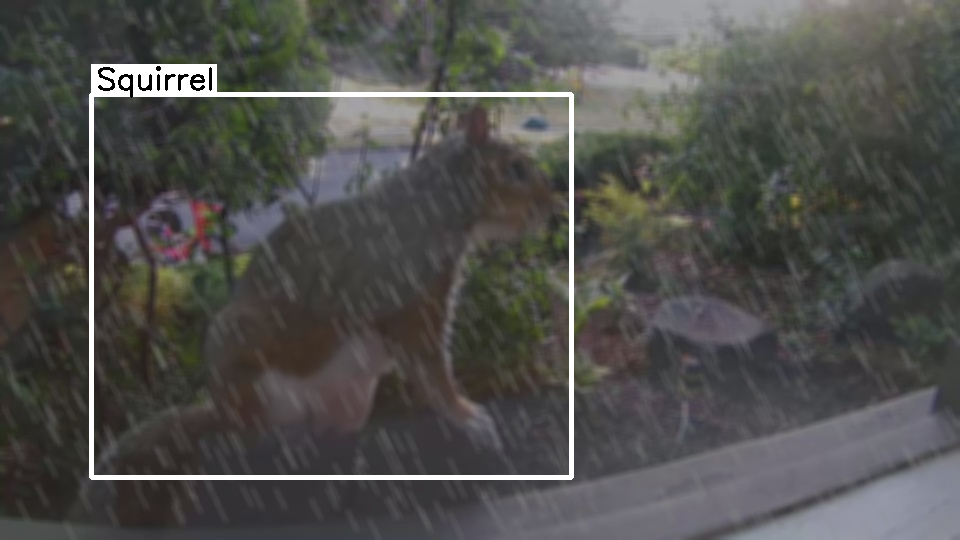

In [49]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T07-23-10-frame_0002_augmented_3.jpeg")

Export the augmented dataset in the format of your choice. 

In [12]:
dataset.export.ExportToYoloV5(output_path='training/labels', yaml_file='dataset.yaml', copy_images=True, cat_id_index=0)


['training/dataset.yaml',
 'training/labels/2021-07-03T06-30-10-frame_0001.txt',
 'training/labels/2021-07-03T06-47-39-frame_0004.txt',
 'training/labels/2021-07-03T07-15-45-frame_0001.txt',
 'training/labels/2021-07-03T07-15-45-frame_0000.txt',
 'training/labels/2021-07-03T06-30-10-frame_0000.txt',
 'training/labels/2021-07-03T07-23-10-frame_0009.txt',
 'training/labels/2021-07-03T06-30-10-frame_0002.txt',
 'training/labels/2021-07-03T07-15-45-frame_0002.txt',
 'training/labels/2021-07-03T07-55-47-frame_0008.txt',
 'training/labels/2021-07-03T06-44-59-frame_0002.txt',
 'training/labels/2021-07-03T07-55-47-frame_0009.txt',
 'training/labels/2021-07-03T07-15-45-frame_0003.txt',
 'training/labels/2021-07-03T06-30-10-frame_0003.txt',
 'training/labels/2021-07-03T07-23-10-frame_0008.txt',
 'training/labels/2021-07-03T06-47-39-frame_0002.txt',
 'training/labels/2021-07-03T06-47-39-frame_0003.txt',
 'training/labels/2021-07-03T06-47-39-frame_0001.txt',
 'training/labels/2021-07-03T06-47-39-f